In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [32]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
import seaborn as sns
sns.set()

def corrPlot(df):
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    corr = df.corr()
    sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

def getReport(predictions, flag):
    if flag == 'test':
        theDf = target_test
    elif flag == 'val':
        theDf = target_val
    print("Balanced_Accuracy:", balanced_accuracy_score(theDf, predictions))
    print(classification_report(theDf, predictions))
    
def plotROC(model, flag):
    if flag == 'test':
        features = features_test
        target = target_test
    elif flag == 'val':
        features = features_val
        target = target_val
    probabilities = model.predict_proba(features)
    preds = probabilities[:,1]
    fpr, tpr, threshold = roc_curve(target, preds)
    roc_auc = auc(fpr, tpr)
    
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    #plt.show()
    
    return plt

### Reading in Data

In [55]:
features = pd.read_csv('../datFiles/features.csv', index_col = 0)
target = pd.read_csv('../datFiles/target.csv', index_col = 0, header = None, squeeze = True)

### Testing Transformations for PCA

In [56]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import FunctionTransformer

logTransform = FunctionTransformer(np.log1p, validate = True)

#features = StandardScaler().fit_transform(features)
#features = Normalizer().fit_transform(features)
#features = logTransform.fit_transform(features)


from sklearn.model_selection import train_test_split
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.1, random_state=0, )
features_train, features_val, target_train, target_val = train_test_split(features_train, target_train, test_size = 0.3, random_state = 0)

### PCA

Running experiments w/ 112 state vs 2 state PCA

In [57]:
from sklearn.decomposition import PCA

pca = PCA(n_components=.95, random_state=0)

pca.fit(features_train)

features_train = pca.transform(features_train)
features_test = pca.transform(features_test)
features_val = pca.transform(features_val)


# print(pca.explained_variance_ratio_)
# print(sum(pca.explained_variance_ratio_))

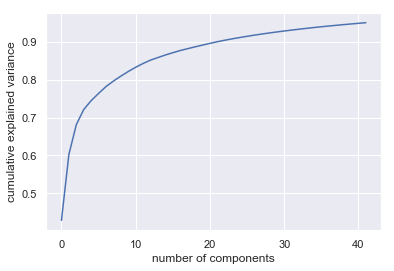

In [58]:
#pca = PCA().fit(digits.data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

### Finding Eigenvalues

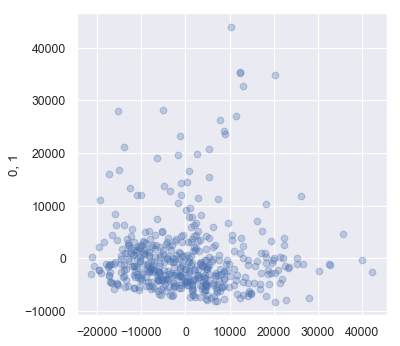

In [59]:
import seaborn as sns
sns.set()

figure(num=None, figsize=(5, 5), dpi=80, facecolor='w', edgecolor='k')

plt.scatter(features_train[:, 0], features_train[:, 1], alpha = 0.3)
plt.ylabel('0, 1')

savefig('../images/PCA_IMAGES/pca_nothing.png')

In [9]:
features_test.shape

(75, 70)

In [10]:
features_train.shape

(467, 70)

In [11]:
features_val.shape

(201, 70)

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV


logit = LogisticRegression(solver='liblinear', max_iter=500)

best_logit = LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=0.0001, max_iter=500, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

penalties = ['l1', 'l2']
tols = [1e-2, 1e-3, 1e-4]
costs = [0.001, 0.01, 0.1, 1, 5, 10]
intercepts = [0.0001, 0.001, 0.1, 1]
fit_intercepts = [True, False]
classWeights = [None, 'balanced']

params_logit = {'C': costs, 'penalty': penalties, 'tol': tols, 
                'fit_intercept': fit_intercepts, 'class_weight': classWeights, 'intercept_scaling': intercepts}

gs_logit = GridSearchCV(logit, params_logit, cv=10)

best_logit.fit(features_train, target_train)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=0.0001, max_iter=500, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

Balanced_Accuracy: 0.708713503649635
              precision    recall  f1-score   support

         0.0       0.83      0.73      0.78       137
         1.0       0.54      0.69      0.61        64

   micro avg       0.72      0.72      0.72       201
   macro avg       0.69      0.71      0.69       201
weighted avg       0.74      0.72      0.72       201



<module 'matplotlib.pyplot' from '/Users/hhuang85/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

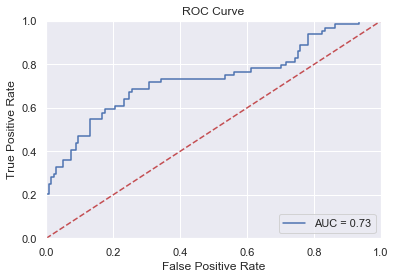

In [13]:
predictions = best_logit.predict(features_val)
getReport(predictions, 'val')
plotROC(best_logit, 'val')

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=0)

num_trees = [10, 15, 20, 25, 30, 40, 50]
criterion = ['gini']
max_depth = [10, 20, 30]
min_samples_leaf = [1,2,3,4]
min_samples_split = [1,2,3,4]

params_rf = {'n_estimators': num_trees, 'criterion': criterion, 'max_depth': max_depth}
gs_rf = GridSearchCV(rf, params_rf, cv=10)

gs_rf.fit(features_train, target_train)
gs_rf.best_estimator_

In [ ]:
predictions = gs_rf.predict(features_val)
getReport(predictions, 'val')
plotROC(gs_rf, 'val')

In [ ]:
predictions = gs_rf.predict(features_test)
getReport(predictions, 'test')
plotROC(gs_rf, 'test')